# Business Understanding

- [ ] analysis of requirements with the end user
- [ ] definition of business goals
- [ ] translation of business goals into data mining goals
- [ ] Tools and project management

## Business Objectives

**Descriptive problem**: TODO

**Predictive problem**: Predict whether a loan will end successfully.

- Classification problem
- Target: *status* column of *loan_dev.csv* file (-1 = bad, 1 = good)
- Minority (positive) class: Loan not paid (*status* = -1)
- Evaluation metric: AUC
- Reduce defaulting (minimize FPR), for example FPR < 0.25
- Don't reduce credit card approval (maximize FNR), for example FNR > 0.95


## ~~Assess Situation~~

## Data Mining Goals (TODO)

Parte disto deve estar em Business Objectives, mas não sei o que é o quê

## Project Plan (TODO)

- Methodology: CRISP-DM
- plan: TODO ?????????
- Project Management tools: ??????
- collaboration tools: Github? (idk if this is what they mean)
- Analytics Tools: ?????
- Database Tools: ?????
- other tools (e.g. data cleaning, visualization): ????


    

# Data Understanding
    
- [ ] diversity of statistical methods
- [ ] complexity of statistical methods
- [ ] interpretation of results of statistical methods
- [ ] knowledge extraction from results of statistical methods
- [ ] diversity of plots
- [ ] complexity of plots
- [ ] presentation
- [ ] interpretation of plots
- [ ] visual knowledge extraction

## Collected Data

- account.csv - relation account (4500 objects) 
- client.csv - relation client (5369 objects)
- disp.csv - relation disposition (5369 objects) 
- district.csv - relation demographic data (77 objects)
- ~~relation permanent order (0/6471 objects)~~
- trans_dev.csv - relation transaction (396685/1056320 objects)
- card_dev.csv - relation credit card (177/892 objects)
- loan_dev.csv - relation loan (328/682 objects)

    - account has 4500/4500 objects (missing 0.00%)
    - client has 5369/5369 objects (missing 0.00%)
    - disp has 5369/5369 objects (missing 0.00%)
    - district has 77/77 objects (missing 0.00%)
    - card has 177/892 objects (missing 80.16%)
    - transaction has 396685/1056320 objects (missing 62.45%)
    - loan has 328/682 objects (missing 51.91%)
    - orders file doesn't exist




In [74]:
import os
import uuid
import numpy as np 
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# This is used in order to show the plotted figures within this notebook
%matplotlib inline 
# This is used in order to show the tensorboard within this notebook             
#%load_ext tensorboard  
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
import missingno as msno


In [75]:
# Utils
def dict_barplot(dict):
    """From a dict {x:y} it plots a barplot"""
    lenx = len(dict.keys())
    plt.figure(figsize=(lenx/4, 4))
    plt.bar(range(lenx), list(dict.values()), align='center')
    plt.xticks(range(lenx), list(dict.keys()), rotation=90)
    plt.show()


In [76]:
accounts = pd.read_csv('data/account.csv', sep=';')
cards = pd.read_csv('data/card_dev.csv', sep=';')
clients = pd.read_csv('data/client.csv', sep=';')
disp = pd.read_csv('data/disp.csv', sep=';')
districts = pd.read_csv('data/district.csv', sep=';')
loans = pd.read_csv('data/loan_dev.csv', sep=';')
trans = pd.read_csv('data/trans_dev.csv', sep=';')

C:\Users\PedroGoncaloCorreia\AppData\Local\Temp\ipykernel_21552\683704619.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans = pd.read_csv('data/trans_dev.csv', sep=';')


In [77]:
def info(table, name):
    print("==============")
    print(name)
    print("--------------")
    print(table.info(verbose=True, max_cols=1000, memory_usage=False, show_counts=True))

info(accounts, "accounts")
info(cards, "cards_dev")
info(clients, "clients")
info(disp, "disp")
info(districts, "districts")
info(loans, "loans_dev")
info(trans, "transactions_dev")


accounts
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   int64 
dtypes: int64(3), object(1)None
cards_dev
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  177 non-null    int64 
 1   disp_id  177 non-null    int64 
 2   type     177 non-null    object
 3   issued   177 non-null    int64 
dtypes: int64(3), object(1)None
clients
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  ----

Null values: Only transactions_dev has null values: operation, k_symbol, bank, account
Dates: We should confirm that for a loan in a given date we only consider accounts/clients/transactions/etc from before that date, using the respective date fields

accounts : 4500 objects
 #  | Column    |   Non-Null Count | type 
--- | ------     |  -------------- | ----- 
 0 |  account_id  | 4500 non-null |  PRIMARY KEY 
 1  | district_id|  4500 non-null |  FOREIGN KEY 
 2  | frequency  |  4500 non-null |  enum('monthly issuance', 'issuance after transaction', 'weekly issuance')
 3  | date       |  4500 non-null |  YYMMDD

- categorize/encode frequency, no order (TODO: why no order? there seems to be a order: after < weekly < monthly)
- parse date
- join on acc_id and distr_id

clients : 5369 objects
 #  | Column        |Non-Null Count|  type
--- | ------        |--------------|  -----
 0  | client_id     |5369 non-null |  PRIMARY KEY
 1  | birth_number | 5369 non-null |  YYMMDD + 5000 if woman
 2   |district_id |  5369 non-null |  FOREIGN KEY

- parse birth date
- retrieve sex and birth_date from birth_number

disp : 5369 objects
 #  | Column     | Non-Null Count | type 
--- | ------     | -------------- | ----- 
 0  | disp_id    | 5369 non-null  | PRIMARY KEY 
 1  | client_id  | 5369 non-null  | FOREIGN KEY 
 2  | account_id | 5369 non-null  | FOREIGN KEY 
 3  | type       | 5369 non-null  | enum('OWNER', 'DISPONENT')

- categorize/encode frequency, (0 = disponent, 1 = owner)

districts : 77 objects
 #  | Column                                            | Non-Null Count | type  
--- | ------                                            | -------------- | -----  
 0  | code                                              | 77 non-null    | PRIMARY KEY  
 1  | name                                              | 77 non-null    | UNIQUE KEY 
 2  | region                                            | 77 non-null    | enum('Prague', 'central Bohemia', 'south Bohemia', 'west Bohemia', 'north Bohemia', 'east Bohemia', 'south Moravia', 'north Moravia')
 3  | no. of inhabitants                                | 77 non-null    | int  
 4  | no. of municipalities with inhabitants < 499      | 77 non-null    | int  
 5  | no. of municipalities with inhabitants 500-1999   | 77 non-null    | int  
 6  | no. of municipalities with inhabitants 2000-9999  | 77 non-null    | int  
 7  | no. of municipalities with inhabitants >10000     | 77 non-null    | int  
 8  | no. of cities                                     | 77 non-null    | int  
 9  | ratio of urban inhabitants                       |  77 non-null    | float
 10 | average salary                                  |   77 non-null    | int (currency unit)  
 11 | unemploymant rate '95                          |    77 non-null    | float 
 12 | unemploymant rate '96                         |     77 non-null    | float
 13 | no. of enterpreneurs per 1000 inhabitants    |      77 non-null    | int  
 14 | no. of commited crimes '95                  |       77 non-null    | int 
 15 | no. of commited crimes '96                 |        77 non-null    | int  

transactions_dev : 396685/1056320 objects
 #  | Column    |  Non-Null Count |  type  
--- | ------    |  -------------- |  -----  
 0  | trans_id  |  396685 non-null|  PRIMARY KEY  
 1  | account_id|  396685 non-null|  FOREIGN KEY  
 2  | date      |  396685 non-null|  YYMMDD
 3  | type      |  396685 non-null|  enum('credit', 'withdrawal', 'withdrawal in cash') 
 4  | operation |  325924 non-null|  enum('credit in cash', 'collection from another bank', 'withdrawal in cash', 'remittance to another bank', 'credit card withdrawal')
 5  | amount    |  396685 non-null|  float64 (currency unit)
 6  | balance   |  396685 non-null|  float64 (currency unit)
 7  | k_symbol  |  211441 non-null|  enum('interest credited', ' ', 'household', 'payment for statement', 'insurrance payment', 'sanction interest if negative balance', 'old-age pension')
 8  | bank      |  97242 non-null |  string (other bank ID)
 9  | account   |  102229 non-null|  account (other bank's account ID)

- type="withdrawal in cash" is redundant with operation="withdrawal in cash"
- parse date
- encode type, operation, bank
- handle nulls on operation, k_symbol, bank and account

cards_dev : 177/892 objects
 #  | Column  | Non-Null Count | type 
--- | ------  | -------------- | ----- 
 0  | card_id | 177 non-null   | PRIMARY KEY 
 1  | disp_id | 177 non-null   | FOREIGN KEY 
 2  | type    | 177 non-null   | enum('classic', 'junior', 'gold')
 3  | issued  | 177 non-null   | YYMMDD 

- encode type, ordered
- parse issued

loans_dev : 328/682 objects
 #  | Column     | Non-Null Count | type
--- | ------     | -------------- | -----
 0  | loan_id    | 328 non-null   | PRIMARY KEY
 1  | account_id | 328 non-null   | FOREIGN KEY
 2  | date       | 328 non-null   | YYMMDD
 3  | amount     | 328 non-null   | derived(duration*payments)
 4  | duration   | 328 non-null   | int (number of months)
 5  | payments   | 328 non-null   | int (currency unit/month)
 6  | **status** |     328 non-null  |  TARGET (1 = paid, -1 = not paid)

- parse date
- binarize status (1 = not paid, 0 = paid)
- encode duration by year (is by month atm, but always multiples of 12)
- normalize amount OR payments
- remove payments OR amount


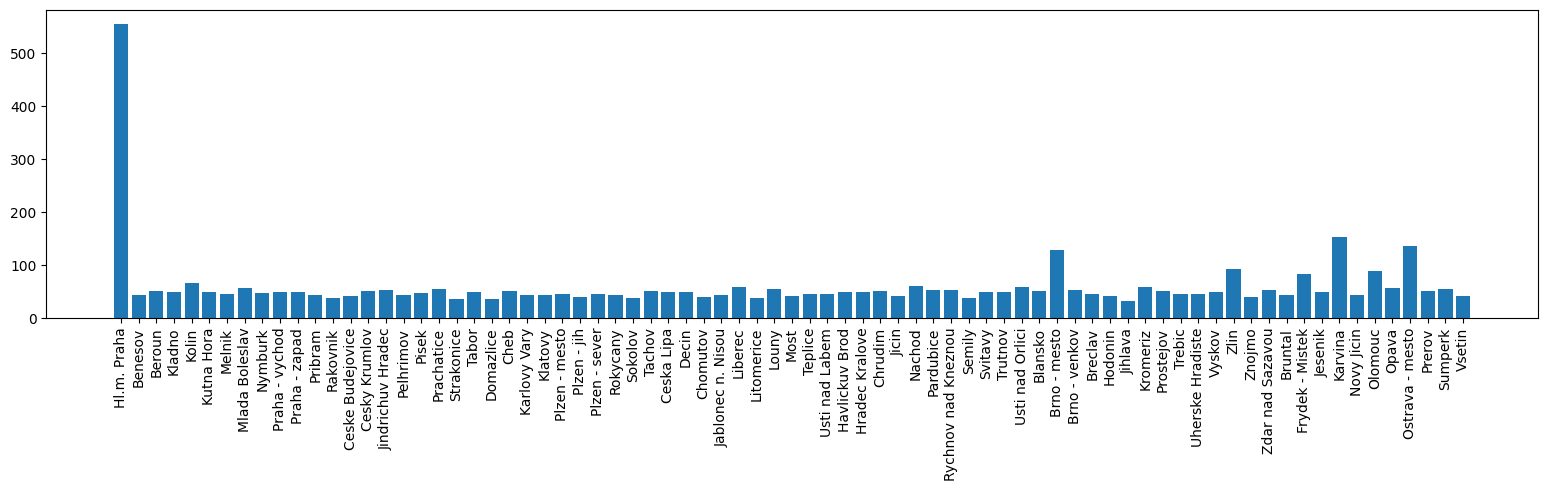

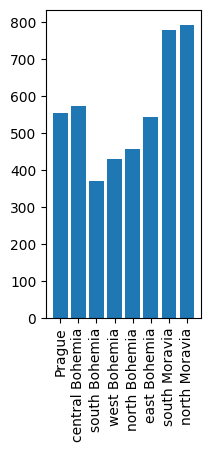

In [78]:
# Account -*----------1-> District

# How many accounts have each district

accounts_count_per_district_array = accounts.value_counts('district_id').sort_index().array
accounts_count_per_district = { name: accounts_count_per_district_array[idx - 1] for idx, name in districts[['code ', 'name ']].values}


accounts_count_per_region = {} 
for idx, region in districts[['code ', 'region']].values:
    accounts_count_per_region[region] = accounts_count_per_region.get(region, 0) + accounts_count_per_district_array[idx - 1]

dict_barplot(accounts_count_per_district)
dict_barplot(accounts_count_per_region)

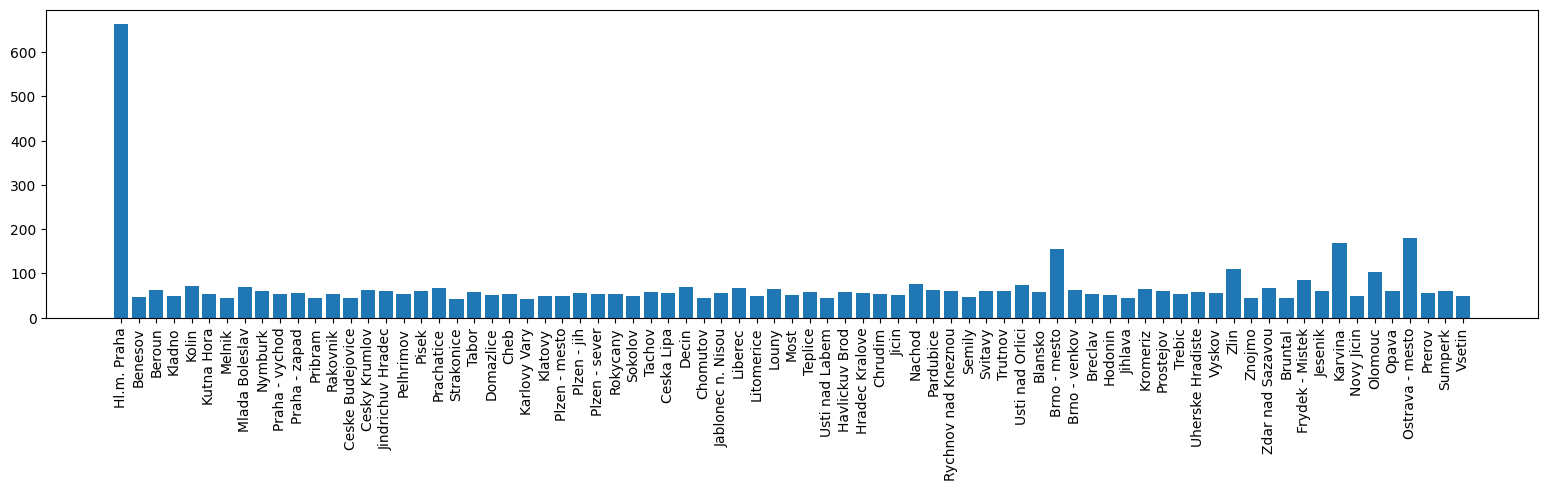

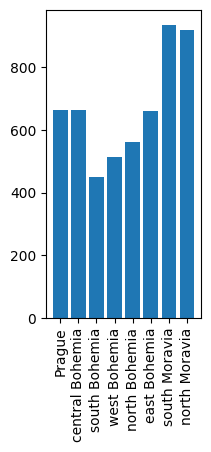

In [79]:
# Client -*----------1-> District

# How many clients have each district

client_count_per_district_array = clients.value_counts('district_id').sort_index().array
client_count_per_district = { name: client_count_per_district_array[idx - 1] for idx, name in districts[['code ', 'name ']].values}


client_count_per_region = {} 
for idx, region in districts[['code ', 'region']].values:
    client_count_per_region[region] = client_count_per_region.get(region, 0) + client_count_per_district_array[idx - 1]

dict_barplot(client_count_per_district)
dict_barplot(client_count_per_region)

In [80]:
# Account <-1----------1..2- Disposition -1----------1-> Client


clients_dict = {}
for idx, client, account, type in disp[['disp_id', 'client_id', 'account_id', 'type']].values:
    if client in clients_dict:
        print("DUPLICATE CLIENT", clients_dict[client])
        # THERE ARE NO DUPLICATE CLIENTS: client_id is just as unique as disp_id
        
    clients_dict[client] = clients_dict.get(client, 0) + 1

print("No clients missing from disposition:", set(clients['client_id'].values) == set(disp['client_id'].values))
print("No accounts missing from disposition:", set(accounts['account_id'].values) == set(disp['account_id'].values))

# EVERY ACCOUNT HAS 1 OWNER AND 0..1 DISPONENTS
for account in set(accounts['account_id'].values):
    disp_row = disp[disp['account_id'] == account]
    types = disp_row['type'].value_counts()
    if types.get('OWNER', 0) != 1:
        print("Account", account, "has", types.get('OWNER', 0), "owners")
    if types.get('DISPONENT', 0) != 0 and types.get('DISPONENT', 0) != 1:
        print("Account", account, "has", types.get('DISPONENT', 0), "disponents")

No clients missing from disposition: True
No accounts missing from disposition: True


In [81]:
# acc_district != owner_district != disponent_district
for account, acc_district in accounts[['account_id', 'district_id']].values:
    disp_row = disp[disp['account_id'] == account]
    owner_id = disp_row[disp_row['type'] == 'OWNER']['client_id'].values[0]
    owner = clients[clients['client_id'] == owner_id]
    owner_district = owner['district_id'].values[0]

    disponent_id = disp_row[disp_row['type'] == 'DISPONENT']
    if disponent_id.shape[0] == 1:
        disponent_id = disponent_id['client_id'].values[0]
        disponent = clients[clients['client_id'] == disponent_id]
        disponent_district = disponent['district_id'].values[0]
        print(acc_district, owner_district, disponent_district)
    else:
        print(acc_district, owner_district)


55 74 74
74 1 1
55 22 22
16 16
24 24
77 46
1 64
47 76 76
74 74
76 76
48 48 48
70 70
19 19
62 28
6 75
21 5
70 70
44 44
37 58 58
10 25
41 41
36 36 36
1 1
26 9 9
55 55
1 1
7 8
68 29
54 54
41 49
38 38
1 1
41 41
38 38
1 1
9 9
60 60
44 34
26 27 27
37 37
74 74 74
14 40
3 3 3
44 41
44 44
53 53
1 15
50 50
33 33 33
15 15
4 4
55 55 55
15 54
32 32
1 1
54 54
40 40 40
54 54 54
66 19
27 27
49 49
47 47
45 1
52 14
74 44
60 60 60
73 21
41 50
74 74 74
25 8
41 41
68 70
23 23
66 66
75 75
1 1
54 3
77 77
1 1
68 68 68
12 4
46 74
13 13
27 27
30 30
48 48
70 40
59 69
32 32
63 63
64 74
61 61 61
72 72
12 14
1 52
40 40
36 13 13
44 30
1 48
17 1
16 15
68 68
64 70
1 1 1
54 15
1 1
7 7
67 45
1 32
32 32
54 54
70 70
14 60
63 63
61 61
64 64 64
48 38
1 31 31
73 28
6 6
70 57
1 77
10 20 20
74 74
24 12
1 1
50 50
6 6
74 74 74
45 45
57 57
6 6
10 10 10
38 75
16 16
75 75
16 16
64 64
51 51
72 43
27 1
46 46
68 46
31 31
1 63
30 38
51 51 51
74 74
13 13
21 21
66 66
51 51
16 16
21 21
68 74 74
30 30 30
1 19
24 59
10 71
71 8
50 50
70 70
2

In [82]:
# Card -0..1----------1-> Disponent
disponents_dict = {}
for idx, disponent in cards[['card_id', 'disp_id']].values:
    if disponent in disponents_dict:
        print("DUPLICATE DISPONENT", disponents_dict[disponent])
        # THERE ARE NO DUPLICATE DISPONENTS: disp_id is just as unique as card_id
    disponents_dict[disponent] = disponents_dict.get(disponent, 0) + 1

print("No disps missing from cards:", set(disp['disp_id'].values) == set(cards['disp_id'].values))

No disps missing from cards: False


In [83]:
# Transaction -0..*----------1-> Account
print("No accounts missing from transactions:", set(accounts['account_id'].values) == set(trans['account_id'].values))

accounts_dict = {account: 0 for account in accounts['account_id'].values}
for idx, account in trans[['trans_id', 'account_id']].values:
    accounts_dict[account] = accounts_dict.get(account, 0) + 1

print("Accounts in dev have between", min(accounts_dict.values()), "and", max(accounts_dict.values()), "transactions")


No accounts missing from transactions: False
Accounts in dev have between 0 and 441 transactions


In [84]:
# Loan -0..1----------1-> Account
accounts_dict = {}
for idx, account in loans[['loan_id', 'account_id']].values:
    if account in accounts_dict:
        print("DUPLICATE ACCOUNT", accounts_dict[account])
        # THERE ARE NO DUPLICATE ACCOUNTS: account_id is just as unique as loan_id
    accounts_dict[account] = accounts_dict.get(account, 0) + 1

print("No accounts missing from loans:", set(accounts['account_id'].values) == set(loans['account_id'].values))

No accounts missing from loans: False


<AxesSubplot: >

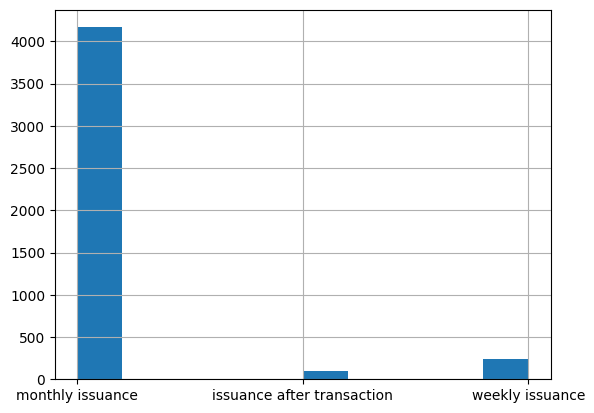

In [85]:
accounts['frequency'].hist()

<AxesSubplot: >

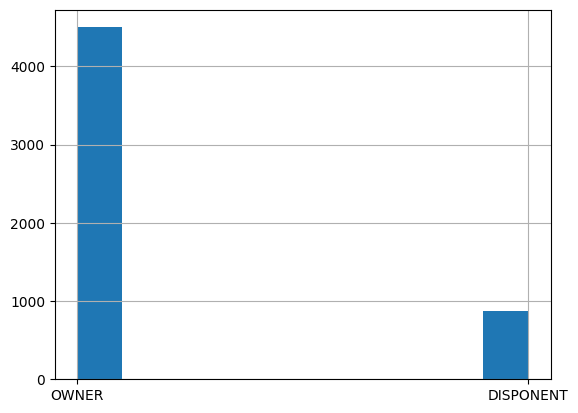

In [86]:
disp['type'].hist()

C:\Users\PedroGoncaloCorreia\AppData\Local\Temp\ipykernel_21552\102409225.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = g.set_xticklabels(g.get_xticklabels(), rotation=90)


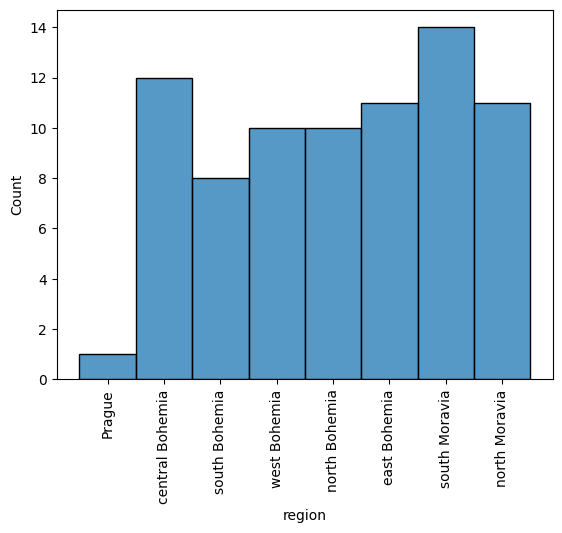

In [87]:
# x labels rotated 90º
g = sns.histplot(districts, x='region')
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)


<AxesSubplot: >

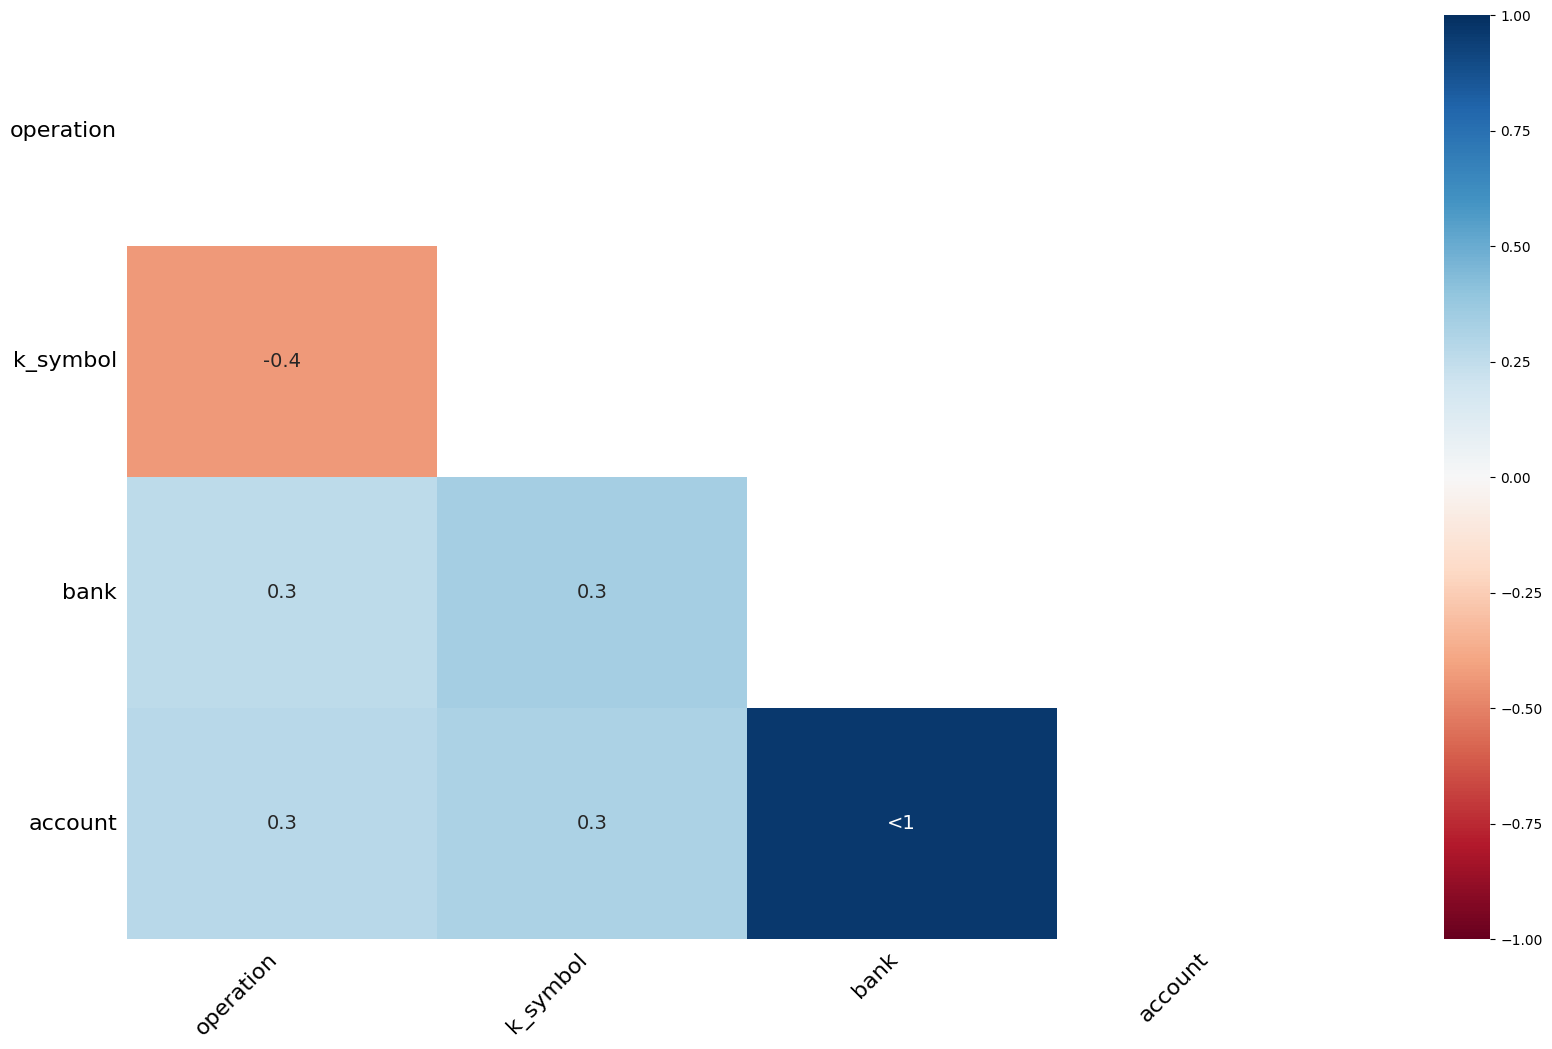

In [88]:
msno.heatmap(trans)

<AxesSubplot: >

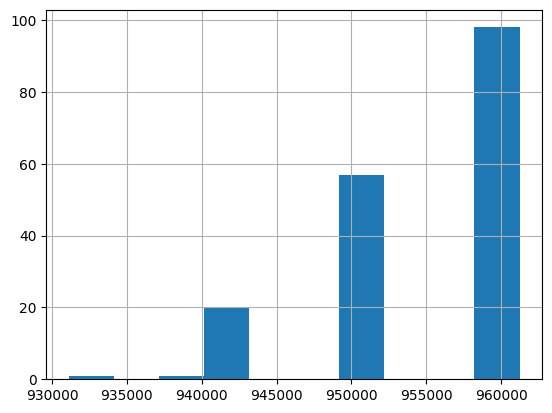

In [89]:
cards['issued'].hist()

<AxesSubplot: xlabel='amount', ylabel='balance'>

C:\Users\PedroGoncaloCorreia\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\PedroGoncaloCorreia\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


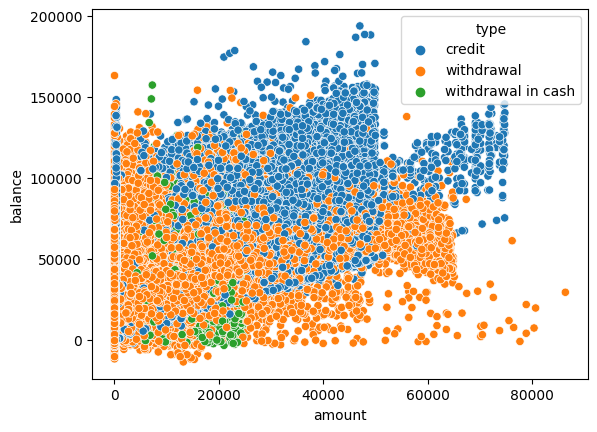

In [90]:
sns.scatterplot(trans, x='amount', y='balance', hue='type')

In [91]:
districts[districts['unemploymant rate \'95 '] == '?']

,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,?,7.01,124,?,1358


In [92]:
districts.replace('?', np.nan, inplace=True)
districts['no. of commited crimes \'95 '] = districts['no. of commited crimes \'95 '].astype(float)
districts['unemploymant rate \'95 '] = districts['unemploymant rate \'95 '].astype(float)

In [93]:
districts['no. of enterpreneurs per 1000 inhabitants '] = districts['no. of enterpreneurs per 1000 inhabitants '] / 1000
districts['no. of commited crimes \'95 '] = districts['no. of commited crimes \'95 '] / districts['no. of inhabitants']
districts['no. of commited crimes \'96 '] = districts['no. of commited crimes \'96 '] / districts['no. of inhabitants']
districts['ratio of urban inhabitants '] = districts['ratio of urban inhabitants '] / 100
districts['unemploymant rate \'95 '] = districts['unemploymant rate \'95 '] / 100
districts['unemploymant rate \'96 '] = districts['unemploymant rate \'96 '] / 100

<AxesSubplot: xlabel='no. of inhabitants', ylabel='Count'>

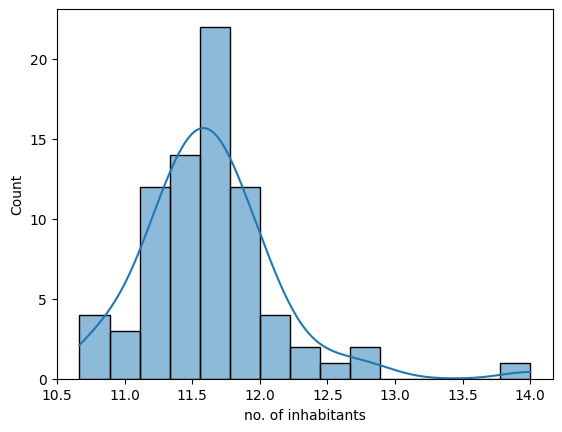

In [94]:

sns.histplot(np.log(districts['no. of inhabitants']), kde=True)

In [95]:
districts['unemploymant rate \'95 '].fillna(districts['unemploymant rate \'95 '].mean(), inplace=True)
districts['no. of commited crimes \'95 '].fillna(districts['no. of commited crimes \'95 '].mean(), inplace=True)
# Potential TODO maybe we could do something more complex, for example a simple linear regression on '96 and '95 columns

In [96]:
districts.drop(['code ', 'region', 'name '], axis=1).describe()

,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
count,7.700000e+01,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,1.338849e+05,48.623377,24.324675,6.272727,1.727273,6.259740,0.630351,9031.675325,0.031193,0.037870,0.116130,0.029905,0.030799
std,1.369135e+05,32.741829,12.780991,4.015222,1.008338,2.435497,0.162217,790.202347,0.016546,0.019085,0.016609,0.011230,0.011534
min,4.282100e+04,0.000000,0.000000,0.000000,0.000000,1.000000,0.339000,8110.000000,0.002900,0.004300,0.081000,0.013543,0.015946
25%,8.585200e+04,22.000000,16.000000,4.000000,1.000000,5.000000,0.519000,8512.000000,0.017900,0.023100,0.105000,0.020961,0.021827
50%,1.088710e+05,49.000000,25.000000,6.000000,2.000000,6.000000,0.598000,8814.000000,0.028300,0.036000,0.113000,0.027359,0.028500
75%,1.390120e+05,71.000000,32.000000,8.000000,2.000000,8.000000,0.735000,9317.000000,0.038500,0.047900,0.126000,0.036375,0.036732
max,1.204953e+06,151.000000,70.000000,20.000000,5.000000,11.000000,1.000000,12541.000000,0.073400,0.094000,0.167000,0.071104,0.082250


In [97]:
districts

,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,1.000,12541,0.0029,0.0043,0.167,0.071104,0.082250
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,0.467,8507,0.0167,0.0185,0.132,0.024290,0.030084
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,0.417,8980,0.0195,0.0221,0.111,0.037537,0.037391
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,0.674,9753,0.0464,0.0505,0.109,0.034985,0.039308
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,0.514,9307,0.0385,0.0443,0.118,0.027359,0.031794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Opava,north Moravia,182027,17,49,12,2,7,0.564,8746,0.0333,0.0374,0.090,0.023925,0.024354
73,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,1.000,10673,0.0475,0.0544,0.100,0.057992,0.056649
74,75,Prerov,north Moravia,138032,67,30,4,2,5,0.646,8819,0.0538,0.0566,0.099,0.029435,0.032637
75,76,Sumperk,north Moravia,127369,31,32,13,2,7,0.512,8369,0.0473,0.0588,0.107,0.029332,0.022038


In [98]:
df = pd.merge(loans, accounts, on='account_id', how='left', suffixes=('_loan', '_account'), validate='one_to_one')
df = pd.merge(df, districts, left_on='district_id', right_on='code ', how='left', suffixes=(None, '_account_district'), validate='many_to_one')

reduced_disp = pd.merge(disp, clients, on='client_id', how='left', suffixes=('_disp', '_client'), validate='one_to_one')
reduced_disp = pd.merge(reduced_disp, cards, on='disp_id', how='left', suffixes=('_disp', '_card'), validate='one_to_one')

reduced_disp['type_card'] = reduced_disp['type_card'].fillna('no card')
reduced_disp = pd.merge(reduced_disp, districts, left_on='district_id', right_on='code ', how='left', suffixes=(None, '_client_district'), validate='many_to_one')

owners = reduced_disp[reduced_disp['type_disp'] == 'OWNER']
owners.columns = owners.columns.map(lambda x: str(x) + '_owner' if x != 'account_id' else x)

disponents = reduced_disp[reduced_disp['type_disp'] == 'DISPONENT']
disponents.columns = disponents.columns.map(lambda x: str(x) + '_disponent' if x != 'account_id' else x)

df = pd.merge(df, owners, on='account_id', how='left', suffixes=(None, '_something_wrong'), validate='one_to_one')
df = pd.merge(df, disponents, on='account_id', how='left', suffixes=(None, '_something_wrong'), validate='one_to_one')

In [99]:
def filter_relevants(trans_dev, account_id, date):
    return trans_dev.loc[trans_dev['account_id'] == account_id].loc[trans_dev['date'] < date]

rows_trans_dev = [filter_relevants(trans, row['account_id'], row['date_loan']) for _, row in df.iterrows()]

def count_condition(df, condition):
    return df.loc[condition].shape[0]

def find_credit(subtrans):
    return subtrans.loc[(subtrans['type'] == 'credit') | (subtrans['operation'] == 'credit in cash')]

def find_withdrawal(subtrans):
    return subtrans.loc[(subtrans['type'] == 'withdrawal') | (subtrans['type'] == 'withdrawal in cash') | (subtrans['operation'] == 'withdrawal in cash') | (subtrans['operation'] == 'credit card withdrawal')]

def signed_mean(subtrans):
    return (
        pd.concat([
            find_credit(subtrans)['amount'],
            -find_withdrawal(subtrans)['amount']
        ])
    ).mean()

df['count_trans_credits'] = [find_credit(subtrans).shape[0] for subtrans in rows_trans_dev]
df['count_trans_withdrawals'] = [find_withdrawal(subtrans).shape[0] for subtrans in rows_trans_dev]
df['count_trans_credit_cash'] = [count_condition(subtrans, (subtrans['operation'] == 'credit in cash')) for subtrans in rows_trans_dev]
df['count_trans_withdrawal_cash'] = [count_condition(subtrans, (subtrans['operation'] == 'withdrawal in cash') | (subtrans['type'] == 'withdrawal in cash')) for subtrans in rows_trans_dev]
df['count_trans_withdrawal_card'] = [count_condition(subtrans, (subtrans['operation'] == 'credit card withdrawal')) for subtrans in rows_trans_dev]
df['count_trans_collection_other_bank'] = [count_condition(subtrans, (subtrans['operation'] == 'collection from another bank')) for subtrans in rows_trans_dev]
df['count_trans_remittance_other_bank'] = [count_condition(subtrans, (subtrans['operation'] == 'remittance to another bank')) for subtrans in rows_trans_dev]
df['count_trans_ksymbol_interest_credited'] = [count_condition(subtrans, (subtrans['k_symbol'] == 'interest credited')) for subtrans in rows_trans_dev]
df['count_trans_ksymbol_household'] = [count_condition(subtrans, (subtrans['k_symbol'] == 'household')) for subtrans in rows_trans_dev]
df['count_trans_ksymbol_payment_for_statement'] = [count_condition(subtrans, (subtrans['k_symbol'] == 'payment for statement')) for subtrans in rows_trans_dev]
df['count_trans_ksymbol_insurance_payment'] = [count_condition(subtrans, (subtrans['k_symbol'] == 'insurance payment')) for subtrans in rows_trans_dev]
df['count_trans_ksymbol_sanction_interest_if_negative_balance'] = [count_condition(subtrans, (subtrans['k_symbol'] == 'sanction interest if negative balance')) for subtrans in rows_trans_dev]
df['count_trans_ksymbol_oldage_pension'] = [count_condition(subtrans, (subtrans['k_symbol'] == 'old-age pension')) for subtrans in rows_trans_dev]

# the ones below may be NaN
df['last_trans_balance'] = [subtrans.loc[subtrans['date'] == subtrans['date'].max()]['balance'].values[0] for subtrans in rows_trans_dev]
df['mean_trans_balance'] = [subtrans['balance'].mean() for subtrans in rows_trans_dev]
df['mean_trans_amount_absolute'] = [subtrans['amount'].mean() for subtrans in rows_trans_dev]
df['mean_trans_amount_credit'] = [find_credit(subtrans)['amount'].mean() for subtrans in rows_trans_dev]
df['mean_trans_amount_withdrawal'] = [find_withdrawal(subtrans)['amount'].mean() for subtrans in rows_trans_dev]
df['mean_trans_amount_signed'] = [signed_mean(subtrans) for subtrans in rows_trans_dev]

# potential TODO other ideas: min_balance, max_balance, median_balance


In [100]:
df.isna().any()['mean_trans_amount_withdrawal']

True

In [101]:
df.drop(columns=['account_id', 'disp_id_owner', 'client_id_owner', 'type_disp_owner', 'card_id_owner', 'disp_id_disponent', 'client_id_disponent', 'type_disp_disponent', 'card_id_disponent'], inplace=True)

In [102]:
df['owner_male'] = df['birth_number_owner'].apply(lambda x: 0 if int(str(x)[2:4]) > 12 else 1) # TODO check if this is correct
df['owner_birthdate'] = df['birth_number_owner'].apply(lambda x: x-5000 if int(str(x)[2:4]) > 12 else x)
df['disponent_male'] = df['birth_number_disponent'].apply(lambda x: (0 if int(str(x)[2:4]) > 12 else 1) if not pd.isna(x) else x)
df['disponent_birthdate'] = df['birth_number_disponent'].apply(lambda x: (x-5000 if int(str(x)[2:4]) > 12 else x) if not pd.isna(x) else x)
df.drop(columns=['amount', 'birth_number_owner', 'birth_number_disponent', 'code ', 'code _owner', 'code _disponent'], inplace=True)



In [103]:
df.rename(columns={
    'loan_id': 'Id', 
    'status': 'Predicted',
    'date_loan': 'loan_date', 
    'duration': 'loan_duration', 
    'payments': 'loan_payments', 
    'district_id': 'account_district_code',
    'name ': 'account_district_name', # removed below
    'region': 'account_district_region',
    'no. of inhabitants': 'account_district_no_inhabitants',
    'no. of municipalities with inhabitants < 499 ': 'account_district_no_municipalities_0_499',
    'no. of municipalities with inhabitants 500-1999': 'account_district_no_municipalities_500_1999',
    'no. of municipalities with inhabitants 2000-9999 ': 'account_district_no_municipalities_2000_9999',
    'no. of municipalities with inhabitants >10000 ': 'account_district_no_municipalities_10000_plus',
    'no. of cities ': 'account_district_no_cities',
    'ratio of urban inhabitants ': 'account_district_ratio_urban_inhabitants',
    'average salary ': 'account_district_average_salary',
    'unemploymant rate \'95 ': 'account_district_unemployment_rate_95',
    'unemploymant rate \'96 ': 'account_district_unemployment_rate_96',
    'no. of enterpreneurs per 1000 inhabitants ': 'account_district_no_enterpreneurs_per_1000_inhabitants',
    'no. of commited crimes \'95 ': 'account_district_no_crimes_95',
    'no. of commited crimes \'96 ': 'account_district_no_crimes_96',
    'frequency': 'account_frequency', 
    'date_account': 'account_date', 
    'owner_male': 'owner_male',
    'owner_birthdate': 'owner_birthdate',
    'district_id_owner': 'owner_district_code',
    'name _owner': 'owner_district_name', # removed below
    'region_owner': 'owner_district_region',
    'no. of inhabitants_owner': 'owner_district_no_inhabitants',
    'no. of municipalities with inhabitants < 499 _owner': 'owner_district_no_municipalities_0_499', 
    'no. of municipalities with inhabitants 500-1999_owner': 'owner_district_no_municipalities_500_1999',
    'no. of municipalities with inhabitants 2000-9999 _owner': 'owner_district_no_municipalities_2000_9999',
    'no. of municipalities with inhabitants >10000 _owner': 'owner_district_no_municipalities_10000_plus',
    'no. of cities _owner': 'owner_district_no_cities',
    'ratio of urban inhabitants _owner': 'owner_district_ratio_urban_inhabitants',
    'average salary _owner': 'owner_district_average_salary',
    'unemploymant rate \'95 _owner': 'owner_district_unemployment_rate_95',
    'unemploymant rate \'96 _owner': 'owner_district_unemployment_rate_96',
    'no. of enterpreneurs per 1000 inhabitants _owner': 'owner_district_no_enterpreneurs_per_1000_inhabitants',
    'no. of commited crimes \'95 _owner': 'owner_district_no_crimes_95',
    'no. of commited crimes \'96 _owner': 'owner_district_no_crimes_96',
    'type_card_owner': 'owner_card_type', 
    'issued_owner': 'owner_card_issued',
    'disponent_male': 'disponent_male',
    'disponent_birthdate': 'disponent_birthdate',
    'district_id_disponent': 'disponent_district_code',
    'name _disponent': 'disponent_district_name', # removed below
    'region_disponent': 'disponent_district_region',
    'no. of inhabitants_disponent': 'disponent_district_no_inhabitants',
    'no. of municipalities with inhabitants < 499 _disponent': 'disponent_district_no_municipalities_0_499',
    'no. of municipalities with inhabitants 500-1999_disponent': 'disponent_district_no_municipalities_500_1999',
    'no. of municipalities with inhabitants 2000-9999 _disponent': 'disponent_district_no_municipalities_2000_9999',
    'no. of municipalities with inhabitants >10000 _disponent': 'disponent_district_no_municipalities_10000_plus',
    'no. of cities _disponent': 'disponent_district_no_cities',
    'ratio of urban inhabitants _disponent': 'disponent_district_ratio_urban_inhabitants',
    'average salary _disponent': 'disponent_district_average_salary',
    'unemploymant rate \'95 _disponent': 'disponent_district_unemployment_rate_95',
    'unemploymant rate \'96 _disponent': 'disponent_district_unemployment_rate_96',
    'no. of enterpreneurs per 1000 inhabitants _disponent': 'disponent_district_no_enterpreneurs_per_1000_inhabitants',
    'no. of commited crimes \'95 _disponent': 'disponent_district_no_crimes_95',
    'no. of commited crimes \'96 _disponent': 'disponent_district_no_crimes_96',
    'type_card_disponent': 'disponent_card_type', # removed below
    'issued_disponent': 'disponent_card_issued',  # removed below
    'count_trans_credits': 'count_trans_credits',
    'count_trans_withdrawals': 'count_trans_withdrawals', 
    'count_trans_credit_cash': 'count_trans_credit_cash',
    'count_trans_withdrawal_cash': 'count_trans_withdrawal_cash', 
    'count_trans_withdrawal_card': 'count_trans_withdrawal_card',
    'count_trans_collection_other_bank': 'count_trans_collection_other_bank',
    'count_trans_remittance_other_bank': 'count_trans_remittance_other_bank',
    'count_trans_ksymbol_interest_credited': 'count_trans_ksymbol_interest_credited',
    'count_trans_ksymbol_household': 'count_trans_ksymbol_household',
    'count_trans_ksymbol_payment_for_statement': 'count_trans_ksymbol_payment_for_statement',
    'count_trans_ksymbol_insurance_payment': 'count_trans_ksymbol_insurance_payment',
    'count_trans_ksymbol_sanction_interest_if_negative_balance': 'count_trans_ksymbol_sanction_interest_if_negative_balance',
    'count_trans_ksymbol_oldage_pension': 'count_trans_ksymbol_oldage_pension', 
    'last_trans_balance': 'last_trans_balance',
    'mean_trans_balance': 'mean_trans_balance', 
    'mean_trans_amount_absolute': 'mean_trans_amount_absolute',
    'mean_trans_amount_credit': 'mean_trans_amount_credit', 
    'mean_trans_amount_withdrawal': 'mean_trans_amount_withdrawal',
    'mean_trans_amount_signed': 'mean_trans_amount_signed'
}, inplace=True)

In [104]:
# TODO estou a fazer algo errado? Nunca há colisão de datas?
def check_after_sanity(df, col1, col2):
    cond = (df[col1] > df[col2]) | (df[col1].isna()) | (df[col2].isna())
    notcond = ~cond
    print(f"{col1} > {col2}: {cond.all()} ({notcond.sum()} rows)")

check_after_sanity(df, 'loan_date', 'account_date')
check_after_sanity(df, 'loan_date', 'owner_card_issued')
check_after_sanity(df, 'owner_card_issued', 'account_date')


loan_date > account_date: True (0 rows)
loan_date > owner_card_issued: True (0 rows)
owner_card_issued > account_date: True (0 rows)


In [105]:
disp[disp['disp_id'].isin(cards['disp_id'])]['type'].value_counts()
# All cards are from OWNERS

OWNER    177
Name: type, dtype: int64

In [106]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.to_csv('output/percent_missing.csv')

In [107]:
df['Predicted'] = df['Predicted'].apply(lambda x: 0 if x == 1 else (1 if x == -1 else np.nan))

In [108]:
df

,Id,loan_date,loan_duration,loan_payments,Predicted,account_district_code,account_frequency,account_date,account_district_name,account_district_region,account_district_no_inhabitants,account_district_no_municipalities_0_499,account_district_no_municipalities_500_1999,account_district_no_municipalities_2000_9999,account_district_no_municipalities_10000_plus,account_district_no_cities,account_district_ratio_urban_inhabitants,account_district_average_salary,account_district_unemployment_rate_95,account_district_unemployment_rate_96,account_district_no_enterpreneurs_per_1000_inhabitants,account_district_no_crimes_95,account_district_no_crimes_96,owner_district_code,owner_card_type,owner_card_issued,owner_district_name,owner_district_region,owner_district_no_inhabitants,owner_district_no_municipalities_0_499,owner_district_no_municipalities_500_1999,owner_district_no_municipalities_2000_9999,owner_district_no_municipalities_10000_plus,owner_district_no_cities,owner_district_ratio_urban_inhabitants,owner_district_average_salary,owner_district_unemployment_rate_95,owner_district_unemployment_rate_96,owner_district_no_enterpreneurs_per_1000_inhabitants,owner_district_no_crimes_95,owner_district_no_crimes_96,disponent_district_code,disponent_card_type,disponent_card_issued,disponent_district_name,disponent_district_region,disponent_district_no_inhabitants,disponent_district_no_municipalities_0_499,disponent_district_no_municipalities_500_1999,disponent_district_no_municipalities_2000_9999,disponent_district_no_municipalities_10000_plus,disponent_district_no_cities,disponent_district_ratio_urban_inhabitants,disponent_district_average_salary,disponent_district_unemployment_rate_95,disponent_district_unemployment_rate_96,disponent_district_no_enterpreneurs_per_1000_inhabitants,disponent_district_no_crimes_95,disponent_district_no_crimes_96,count_trans_credits,count_trans_withdrawals,count_trans_credit_cash,count_trans_withdrawal_cash,count_trans_withdrawal_card,count_trans_collection_other_bank,count_trans_remittance_other_bank,count_trans_ksymbol_interest_credited,count_trans_ksymbol_household,count_trans_ksymbol_payment_for_statement,count_trans_ksymbol_insurance_payment,count_trans_ksymbol_sanction_interest_if_negative_balance,count_trans_ksymbol_oldage_pension,last_trans_balance,mean_trans_balance,mean_trans_amount_absolute,mean_trans_amount_credit,mean_trans_amount_withdrawal,mean_trans_amount_signed,owner_male,owner_birthdate,disponent_male,disponent_birthdate
0,5314,930705,12,8033,1,30,weekly issuance,930322,Sokolov,west Bohemia,94812,15,13,8,2,10,0.818,9650,0.0338,0.0367,0.100,0.031483,0.029574,30,no card,NaN,Sokolov,west Bohemia,94812,15,13,8,2,10,0.818,9650,0.0338,0.0367,0.100,0.031483,0.029574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0,4,0,0,0,0,0,0,0,0,0,0,20100.0,12250.000000,5025.000000,5025.000000,NaN,5025.000000,0,470722,NaN,NaN
1,5316,930711,36,4610,0,46,monthly issuance,930213,Nachod,east Bohemia,112709,48,20,7,3,10,0.735,8369,0.0179,0.0231,0.117,0.025322,0.023228,46,no card,NaN,Nachod,east Bohemia,112709,48,20,7,3,10,0.735,8369,0.0179,0.0231,0.117,0.025322,0.023228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,12,12,0,0,8,5,2,3,0,0,0,52208.9,52083.859459,11015.635135,13523.158824,8884.240000,1411.051351,1,680722,NaN,NaN
2,6863,930728,60,2118,0,45,monthly issuance,930208,Jicin,east Bohemia,77917,85,19,6,1,5,0.535,8390,0.0228,0.0289,0.132,0.026695,0.027234,45,no card,NaN,Jicin,east Bohemia,77917,85,19,6,1,5,0.535,8390,0.0228,0.0289,0.132,0.026695,0.027234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,9,2,6,0,5,3,8,1,0,0,0,0,20272.8,30060.954167,5417.458333,5009.733333,6097.000000,844.708333,1,360602,NaN,NaN
3,5325,930803,36,2939,0,12,monthly issuance,930130,Pribram,central Bohemia,107870,84,29,6,1,6,0.580,8754,0.0383,0.0431,0.137,0.035265,0.035858,14,no card,NaN,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,0.748,10045,0.014

<AxesSubplot: xlabel='Predicted', ylabel='count'>

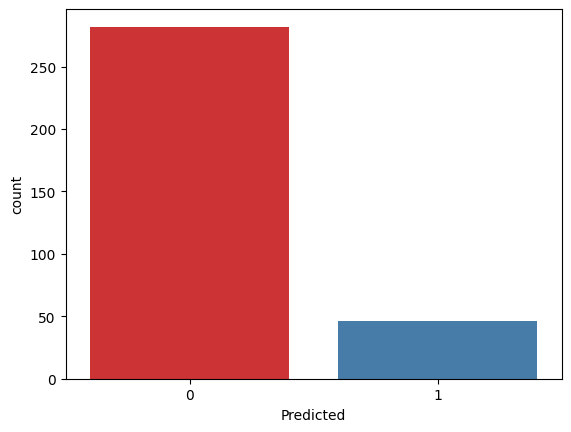

In [109]:
sns.countplot(df, x='Predicted', palette='Set1')

# Unbalanced data, sampling probably needed

C:\Users\PedroGoncaloCorreia\AppData\Local\Temp\ipykernel_21552\2494665367.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


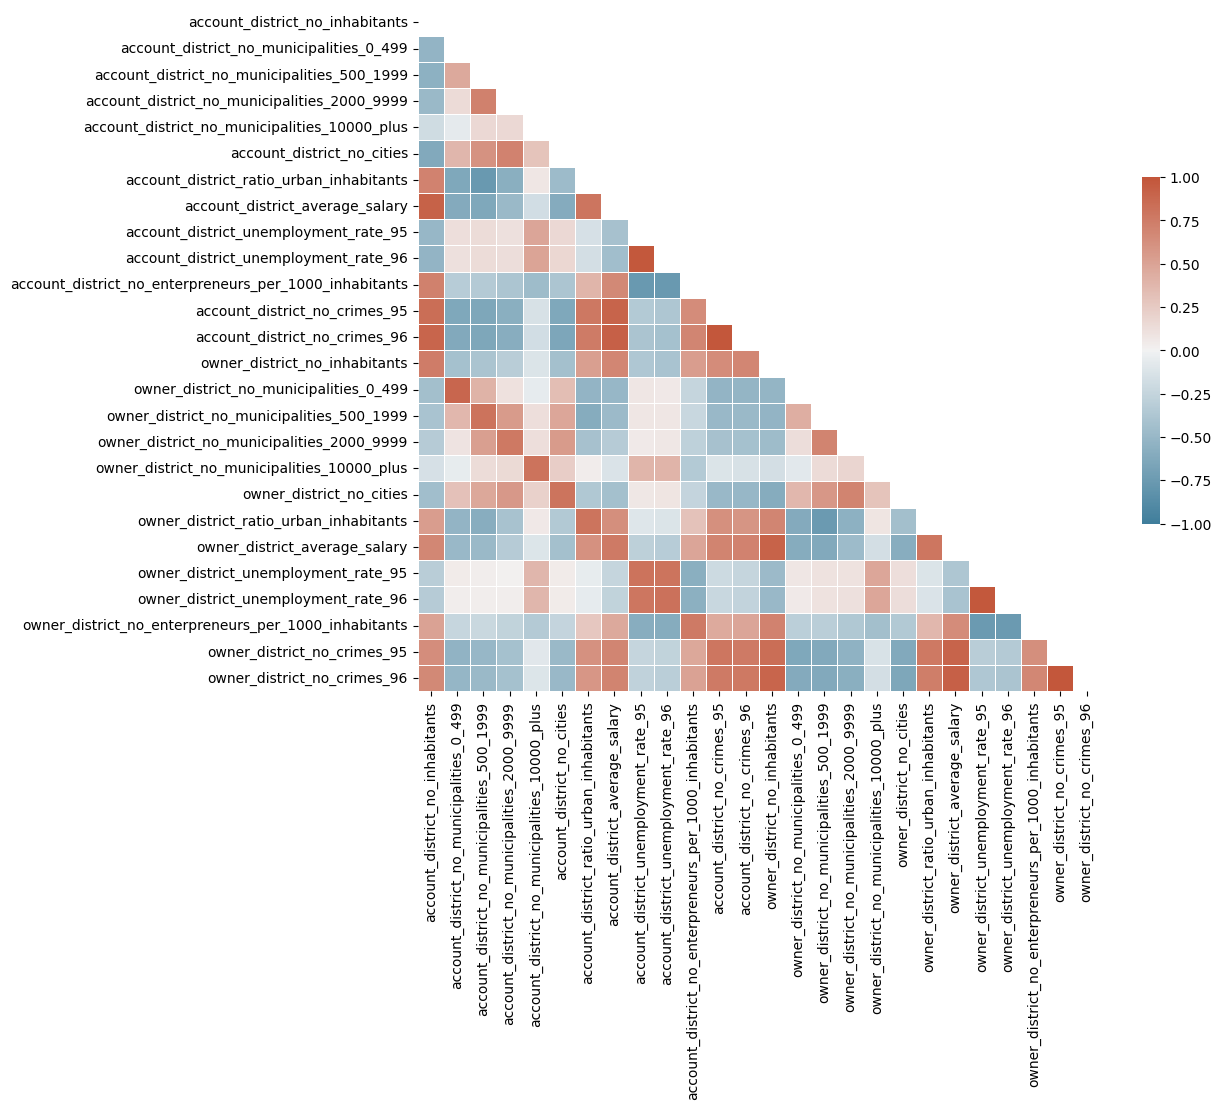

In [110]:
def corr_plot(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr_plot(df[[
    'account_district_region',
    'account_district_no_inhabitants',
    'account_district_no_municipalities_0_499',
    'account_district_no_municipalities_500_1999',
    'account_district_no_municipalities_2000_9999',
    'account_district_no_municipalities_10000_plus',
    'account_district_no_cities',
    'account_district_ratio_urban_inhabitants',
    'account_district_average_salary',
    'account_district_unemployment_rate_95',
    'account_district_unemployment_rate_96',
    'account_district_no_enterpreneurs_per_1000_inhabitants',
    'account_district_no_crimes_95',
    'account_district_no_crimes_96',
    'owner_district_region',
    'owner_district_no_inhabitants',
    'owner_district_no_municipalities_0_499',
    'owner_district_no_municipalities_500_1999',
    'owner_district_no_municipalities_2000_9999',
    'owner_district_no_municipalities_10000_plus',
    'owner_district_no_cities',
    'owner_district_ratio_urban_inhabitants',
    'owner_district_average_salary',
    'owner_district_unemployment_rate_95',
    'owner_district_unemployment_rate_96',
    'owner_district_no_enterpreneurs_per_1000_inhabitants',
    'owner_district_no_crimes_95',
    'owner_district_no_crimes_96',
]])
# Disponent male and owner male correlated negatively (man and woman)


<AxesSubplot: xlabel='last_trans_balance', ylabel='mean_trans_balance'>

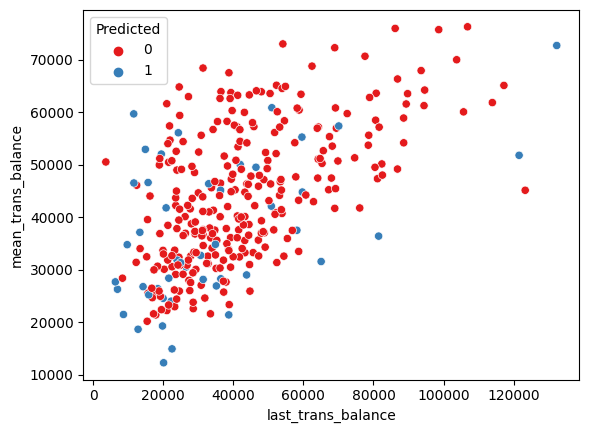

In [111]:
sns.scatterplot(df, y='mean_trans_balance', x='last_trans_balance', hue='Predicted', palette='Set1')

<AxesSubplot: xlabel='count_trans_credits', ylabel='count_trans_withdrawals'>

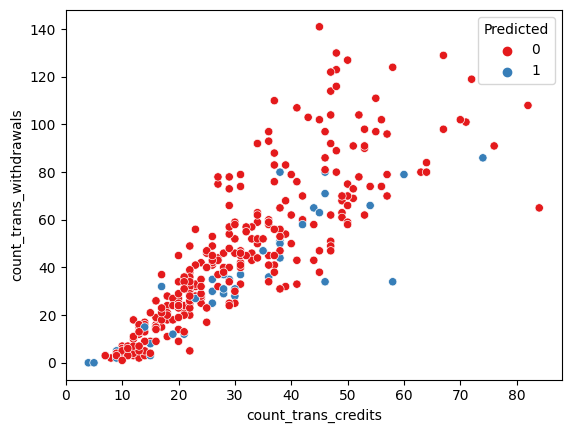

In [112]:
sns.scatterplot(df, x='count_trans_credits', y='count_trans_withdrawals', hue='Predicted', palette='Set1')

# credits and withdrawals are correlated

,Id,loan_date,loan_duration,loan_payments,Predicted,account_district_code,account_frequency,account_date,account_district_name,account_district_region,account_district_no_inhabitants,account_district_no_municipalities_0_499,account_district_no_municipalities_500_1999,account_district_no_municipalities_2000_9999,account_district_no_municipalities_10000_plus,account_district_no_cities,account_district_ratio_urban_inhabitants,account_district_average_salary,account_district_unemployment_rate_95,account_district_unemployment_rate_96,account_district_no_enterpreneurs_per_1000_inhabitants,account_district_no_crimes_95,account_district_no_crimes_96,owner_district_code,owner_card_type,owner_card_issued,owner_district_name,owner_district_region,owner_district_no_inhabitants,owner_district_no_municipalities_0_499,owner_district_no_municipalities_500_1999,owner_district_no_municipalities_2000_9999,owner_district_no_municipalities_10000_plus,owner_district_no_cities,owner_district_ratio_urban_inhabitants,owner_district_average_salary,owner_district_unemployment_rate_95,owner_district_unemployment_rate_96,owner_district_no_enterpreneurs_per_1000_inhabitants,owner_district_no_crimes_95,owner_district_no_crimes_96,disponent_district_code,disponent_card_type,disponent_card_issued,disponent_district_name,disponent_district_region,disponent_district_no_inhabitants,disponent_district_no_municipalities_0_499,disponent_district_no_municipalities_500_1999,disponent_district_no_municipalities_2000_9999,disponent_district_no_municipalities_10000_plus,disponent_district_no_cities,disponent_district_ratio_urban_inhabitants,disponent_district_average_salary,disponent_district_unemployment_rate_95,disponent_district_unemployment_rate_96,disponent_district_no_enterpreneurs_per_1000_inhabitants,disponent_district_no_crimes_95,disponent_district_no_crimes_96,count_trans_credits,count_trans_withdrawals,count_trans_credit_cash,count_trans_withdrawal_cash,count_trans_withdrawal_card,count_trans_collection_other_bank,count_trans_remittance_other_bank,count_trans_ksymbol_interest_credited,count_trans_ksymbol_household,count_trans_ksymbol_payment_for_statement,count_trans_ksymbol_insurance_payment,count_trans_ksymbol_sanction_interest_if_negative_balance,count_trans_ksymbol_oldage_pension,last_trans_balance,mean_trans_balance,mean_trans_amount_absolute,mean_trans_amount_credit,mean_trans_amount_withdrawal,mean_trans_amount_signed,owner_male,owner_birthdate,disponent_male,disponent_birthdate
55,6903,940604,24,2172,0,30,monthly issuance,930913,Sokolov,west Bohemia,94812,15,13,8,2,10,0.818,9650,0.0338,0.0367,0.100,0.031483,0.029574,11,no card,NaN,Praha - zapad,central Bohemia,75637,35,36,9,0,7,0.365,9622,0.0045,0.0059,0.154,0.045943,0.046657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,32,13,32,0,0,0,26,0,5,0,6,0,58659.8,33459.680282,6031.725352,6244.838462,5771.993750,828.801408,0,590717,NaN,NaN
251,5494,960613,48,7500,0,64,issuance after transaction,941113,Zlin,south Moravia,197099,29,41,10,2,10,0.747,9624,0.0160,0.0231,0.145,0.022750,0.021639,64,no card,NaN,Zlin,south Moravia,197099,29,41,10,2,10,0.747,9624,0.0160,0.0231,0.145,0.022750,0.021639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57,79,2,79,0,19,0,36,0,14,0,6,0,64765.2,51149.655147,14897.402206,18340.457895,12413.172152,476.216912,0,730307,NaN,NaN


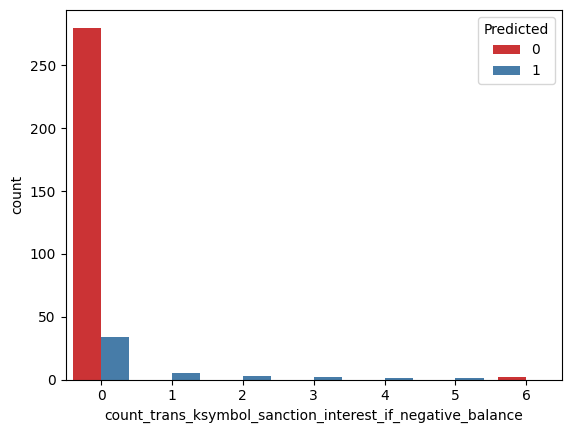

In [113]:
sns.countplot(df, x='count_trans_ksymbol_sanction_interest_if_negative_balance', hue='Predicted', palette='Set1')

df[df['count_trans_ksymbol_sanction_interest_if_negative_balance'] == 6]


<AxesSubplot: xlabel='last_trans_balance', ylabel='loan_payments'>

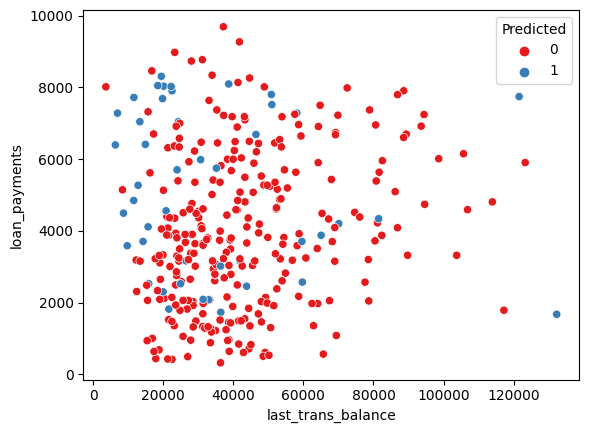

In [114]:
sns.scatterplot(df, x='last trans balance', y='loan payments', hue='Predicted', palette='Set1')
# low last transaction and high payments seem to lead to bad status

<AxesSubplot: xlabel='mean_trans_balance', ylabel='loan_payments'>

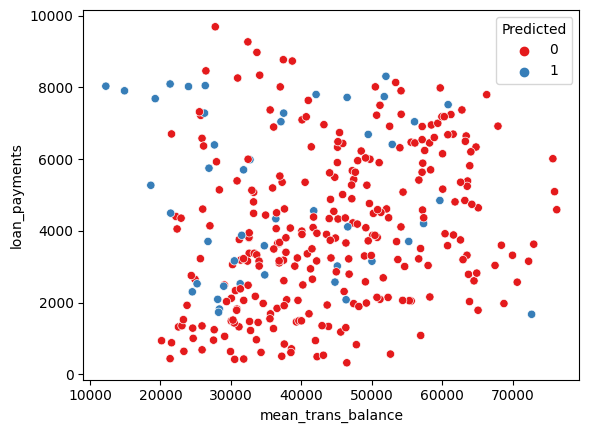

In [115]:
sns.scatterplot(df, x='mean_trans_balance', y='loan_payments', hue='Predicted', palette='Set1')

<AxesSubplot: xlabel='count_trans_ksymbol_household', ylabel='count'>

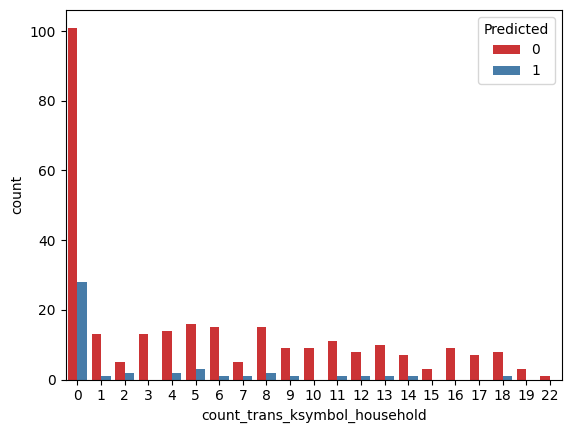

In [116]:
sns.countplot(df, x='count_trans_ksymbol_household', hue='Predicted', palette='Set1')
# 0 count of household transactions seems to lead to bad status
# maybe-TODO check as percentage?

<AxesSubplot: xlabel='count_trans_ksymbol_interest_credited', ylabel='count'>

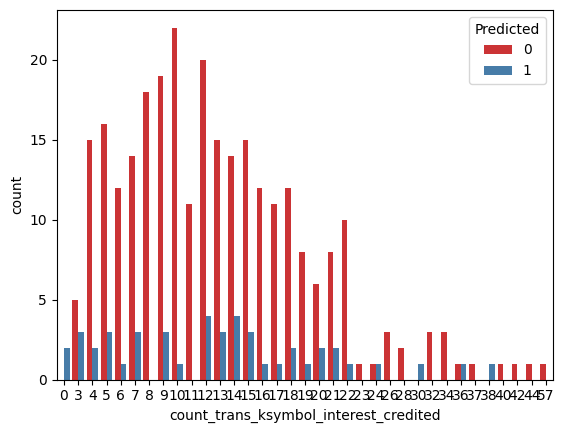

In [117]:
sns.countplot(df, x='count_trans_ksymbol_interest_credited', hue='Predicted', palette='Set1')

In [118]:
df['account_district_region'].value_counts()

south Moravia      64
north Moravia      51
Prague             46
central Bohemia    40
east Bohemia       37
west Bohemia       31
south Bohemia      30
north Bohemia      29
Name: account_district_region, dtype: int64

In [119]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
df.head()

,Id,loan_date,loan_duration,loan_payments,Predicted,account_district_code,account_frequency,account_date,account_district_name,account_district_region,account_district_no_inhabitants,account_district_no_municipalities_0_499,account_district_no_municipalities_500_1999,account_district_no_municipalities_2000_9999,account_district_no_municipalities_10000_plus,account_district_no_cities,account_district_ratio_urban_inhabitants,account_district_average_salary,account_district_unemployment_rate_95,account_district_unemployment_rate_96,account_district_no_enterpreneurs_per_1000_inhabitants,account_district_no_crimes_95,account_district_no_crimes_96,owner_district_code,owner_card_type,owner_card_issued,owner_district_name,owner_district_region,owner_district_no_inhabitants,owner_district_no_municipalities_0_499,owner_district_no_municipalities_500_1999,owner_district_no_municipalities_2000_9999,owner_district_no_municipalities_10000_plus,owner_district_no_cities,owner_district_ratio_urban_inhabitants,owner_district_average_salary,owner_district_unemployment_rate_95,owner_district_unemployment_rate_96,owner_district_no_enterpreneurs_per_1000_inhabitants,owner_district_no_crimes_95,owner_district_no_crimes_96,disponent_district_code,disponent_card_type,disponent_card_issued,disponent_district_name,disponent_district_region,disponent_district_no_inhabitants,disponent_district_no_municipalities_0_499,disponent_district_no_municipalities_500_1999,disponent_district_no_municipalities_2000_9999,disponent_district_no_municipalities_10000_plus,disponent_district_no_cities,disponent_district_ratio_urban_inhabitants,disponent_district_average_salary,disponent_district_unemployment_rate_95,disponent_district_unemployment_rate_96,disponent_district_no_enterpreneurs_per_1000_inhabitants,disponent_district_no_crimes_95,disponent_district_no_crimes_96,count_trans_credits,count_trans_withdrawals,count_trans_credit_cash,count_trans_withdrawal_cash,count_trans_withdrawal_card,count_trans_collection_other_bank,count_trans_remittance_other_bank,count_trans_ksymbol_interest_credited,count_trans_ksymbol_household,count_trans_ksymbol_payment_for_statement,count_trans_ksymbol_insurance_payment,count_trans_ksymbol_sanction_interest_if_negative_balance,count_trans_ksymbol_oldage_pension,last_trans_balance,mean_trans_balance,mean_trans_amount_absolute,mean_trans_amount_credit,mean_trans_amount_withdrawal,mean_trans_amount_signed,owner_male,owner_birthdate,disponent_male,disponent_birthdate
0,5314,930705,12,8033,1,30,weekly issuance,930322,Sokolov,west Bohemia,94812,15,13,8,2,10,0.818,9650,0.0338,0.0367,0.100,0.031483,0.029574,30,no card,NaN,Sokolov,west Bohemia,94812,15,13,8,2,10,0.818,9650,0.0338,0.0367,0.100,0.031483,0.029574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0,4,0,0,0,0,0,0,0,0,0,0,20100.0,12250.000000,5025.000000,5025.000000,NaN,5025.000000,0,470722,NaN,NaN
1,5316,930711,36,4610,0,46,monthly issuance,930213,Nachod,east Bohemia,112709,48,20,7,3,10,0.735,8369,0.0179,0.0231,0.117,0.025322,0.023228,46,no card,NaN,Nachod,east Bohemia,112709,48,20,7,3,10,0.735,8369,0.0179,0.0231,0.117,0.025322,0.023228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,12,12,0,0,8,5,2,3,0,0,0,52208.9,52083.859459,11015.635135,13523.158824,8884.24,1411.051351,1,680722,NaN,NaN
2,6863,930728,60,2118,0,45,monthly issuance,930208,Jicin,east Bohemia,77917,85,19,6,1,5,0.535,8390,0.0228,0.0289,0.132,0.026695,0.027234,45,no card,NaN,Jicin,east Bohemia,77917,85,19,6,1,5,0.535,8390,0.0228,0.0289,0.132,0.026695,0.027234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,9,2,6,0,5,3,8,1,0,0,0,0,20272.8,30060.954167,5417.458333,5009.733333,6097.00,844.708333,1,360602,NaN,NaN
3,5325,930803,36,2939,0,12,monthly issuance,930130,Pribram,central Bohemia,107870,84,29,6,1,6,0.580,8754,0.0383,0.0431,0.137,0.035265,0.035858,14,no card,NaN,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,0.748,10045,0.0142,0.0171

In [120]:
df[['owner_card_type', 'Predicted']].value_counts()

owner_card_type  Predicted
no card          0            271
                 1             46
classic          0              8
gold             0              2
junior           0              1
dtype: int64

In [121]:
df.replace('?', np.nan, inplace=True)

In [122]:
def parse_date_single(x):
    if np.isnan(x):
        return x
    return '19' + str(x)[0:2] + '-' + str(x)[2:4] + '-' + str(x)[4:6]

def parse_date(series):
    return pd.to_datetime(series.apply(lambda x: parse_date_single(x)))

def calculate_age(born, now):
    born = parse_date(born)
    now = parse_date(now)
    born_md = born.apply(lambda x: (x.month, x.day))
    now_md = now.apply(lambda x: (x.month, x.day))
    return now.dt.year - born.dt.year - (now_md < born_md)

def calculate_months(born, now):
    born = parse_date(born)
    now = parse_date(now)
    return (now.dt.year - born.dt.year)*12 + (now.dt.month - born.dt.month) - (now.dt.day < born.dt.day)

df['owner_age'] = calculate_age(df['owner_birthdate'], df['loan_date'])
df['account_age_months'] = calculate_months(df['account_date'], df['loan_date'])
df['disponent_age'] = calculate_age(df['disponent_birthdate'], df['loan_date'])

df[df['owner_age'] < 17][['owner_age', 'disponent_age', 'Predicted']]

,owner_age,disponent_age,Predicted
4,14,NaN,0
5,13,7.0,0
16,14,NaN,0
62,15,NaN,1
69,14,NaN,0
104,15,NaN,0
116,16,NaN,0
142,14,12.0,0
173,14,14.0,0
193,15,NaN,0


In [123]:
df[['owner_age', 'disponent_age', 'account_age_months']].describe()

,owner_age,disponent_age,account_age_months
count,328.000000,75.000000,328.000000
mean,35.756098,33.933333,11.798780
std,12.533318,14.256656,5.379972
min,13.000000,7.000000,3.000000
25%,25.000000,20.000000,7.000000
50%,35.000000,34.000000,12.000000
75%,46.000000,45.500000,16.000000
max,60.000000,60.000000,22.000000


In [124]:
df['has_disponent'] = df['disponent_male'].apply(lambda x: 0 if np.isnan(x) else 1)
df.drop(columns=[
    'disponent_district_region',
    'disponent_district_no_inhabitants',
    'disponent_district_no_municipalities_0_499',
    'disponent_district_no_municipalities_500_1999',
    'disponent_district_no_municipalities_2000_9999',
    'disponent_district_no_municipalities_10000_plus',
    'disponent_district_no_cities',
    'disponent_district_ratio_urban_inhabitants',
    'disponent_district_average_salary',
    'disponent_district_unemployment_rate_95',
    'disponent_district_unemployment_rate_96',
    'disponent_district_no_enterpreneurs_per_1000_inhabitants',
    'disponent_district_no_crimes_95',
    'disponent_district_no_crimes_96',
    'disponent_male',
    'disponent_age',
], inplace=True)

In [125]:
# save data
df.to_csv('output/loan.csv', index=False)

df = df.sort_values(by='loan_date')
competition = df[df['Predicted'].isna()]
data = df[~df['Predicted'].isna()]

data.to_csv('output/loan_dev.csv', index=False)
competition.to_csv('output/loan_comp.csv', index=False)


<AxesSubplot: xlabel='last transaction balance', ylabel='loan payments'>

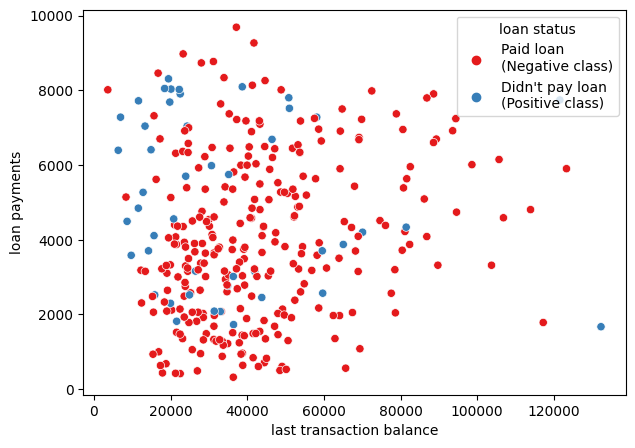

In [241]:
# df.rename(columns={'last_trans_balance': 'last transaction balance'}, inplace=True)
# df['loan duration'].apply(lambda x: f"{x} months")
# df['total loan amount'] = df['loan payments'] * df['loan duration']
plt.figure(figsize=(7, 5))
# plt.title('Monthly loan payments as a function of balance after last transaction')

# plt.xlim(0, 9000)
# plt.ylim(0, 500000)
sns.scatterplot(df, x='last transaction balance', y='loan payments', hue='loan status', palette='Set1', hue_order=[ "Paid loan\n(Negative class)", "Didn't pay loan\n(Positive class)",])
# low last transaction and high payments seem to lead to bad status